# Make new Product Recommendations

# Problem Statement -
Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) ratings_Electronics_Ver3.tar.xz (you may use winrar application to extract the .csv file)

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. 

You can discard the timestamp column as in this case you may not need to use it.
The repository has several datasets. For this case study, please use the Electronics dataset.
The host page has several pointers to scripts and other examples that can help with parsing the datasets.
The data set consists of:
 - 7,824,482 Ratings (1-5) for Electronics products.
 - Other metadata about products. 

Please see the description of the fields available on the web page cited above.

# Mark Distributions -
Step - 1,2,3,8 - 5 marks each

Step - 4,5,6,7 - 10 marks each

# 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter('ignore')

In [2]:
#Loading data
#Read the CSV file and prepare the DF
#For convenience of future use, parse the raw data file (using Python, for example) and 
#extract the following fields: 'product/productId' as prod_id, 'product/title' as prod_name, 
#'review/userId' as user id, 'review/score' as rating

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/ratings_Electronics.csv", skiprows=1, names=['user_id', 'product_id', 'rating', 'timestamp'])
print(data.shape)

#data = pd.read_csv("ratings_Electronics.csv", skiprows=1, names=['user_id', 'product_id', 'rating', 'timestamp'])

Mounted at /content/gdrive
(7824481, 4)


In [0]:
#Save these to a tab separated file. Name this file as product_ratings.csv.
#data.to_csv("product_ratings.csv")

In [4]:
data.head()

user_id  product_id  rating   timestamp
0  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
1  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
2  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
3  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
4  A1QGNMC6O1VW39  0511189877     5.0  1397433600

In [0]:
data.drop('timestamp', axis=1, inplace=True)

In [6]:
data.dtypes

user_id        object
product_id     object
rating        float64
dtype: object

In [7]:
data.nunique()

user_id       4201696
product_id     476001
rating              5
dtype: int64

In [0]:
#There are ~4.2mi users and 476k products and ratings range from 1 to 5

In [9]:
data.shape

(7824481, 3)

In [10]:
#Find the missing value.
#Get missing values isna gives true or false for every cell; total the true's which is 1 to get the null totals
pd.DataFrame((zip(data.columns, data.isna().sum(), data.isnull().sum())), columns=['Features', 'Count_NA', 'Count_NULL']).sort_values('Count_NA', ascending=False)

Features  Count_NA  Count_NULL
0     user_id         0           0
1  product_id         0           0
2      rating         0           0

In [11]:
#print all the data containing nan for check
data[data.isna().any(axis=1)].shape

(0, 3)

In [12]:
data[data.isna().any(axis=1)]

Empty DataFrame
Columns: [user_id, product_id, rating]
Index: []

In [0]:
data.drop(data[data.isna().any(axis=1)].index, inplace=True)

In [14]:
#Find the missing value.
#Get missing values isna gives true or false for every cell; total the true's which is 1 to get the null totals
pd.DataFrame((zip(data.columns, data.isna().sum(), data.isnull().sum())), columns=['Features', 'Count_NA', 'Count_NULL']).sort_values('Count_NA', ascending=False)

Features  Count_NA  Count_NULL
0     user_id         0           0
1  product_id         0           0
2      rating         0           0

In [15]:
data.shape

(7824481, 3)

5.0    55.563302
4.0    18.988876
1.0    11.524918
3.0     8.090926
2.0     5.831978
Name: rating, dtype: float64


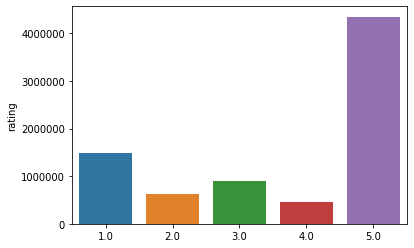

In [16]:
print((100*data['rating'].value_counts()/data['rating'].value_counts().sum()))
sns.barplot(x = data['rating'].unique(), y=data['rating'].value_counts())
plt.show()

Rating 5 is the most given ratings [55%]

# 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [17]:
print("Number if users who have rated more than 50 times", (data['user_id'].value_counts()>=50).sum())

Number if users who have rated more than 50 times 1540


In [0]:
#Get the count per user
user_rating_count = pd.DataFrame((data.groupby('user_id').count().reset_index()[['user_id', 'rating']]))
user_rating_count.columns=['user_id', 'rating_count']

In [19]:
#get users who have reviewerd more than threshold ratings
#filter the users data and ratings data for users lesser than the threshold rating count
rated_atleast_count = 50
user_rating_count = user_rating_count[user_rating_count['rating_count'] >= rated_atleast_count]
print("Number of rows in ratings to be considered for further details", user_rating_count.rating_count.sum(), "involving", user_rating_count.user_id.count(), "products")

Number of rows in ratings to be considered for further details 125871 involving 1540 products


In [20]:
data_filtered = data[data['user_id'].isin(user_rating_count['user_id'])]
data_filtered.shape

(125871, 3)

In [0]:
data_filtered['rating'] = data_filtered['rating'].apply(pd.to_numeric)

5.0    56.433968
4.0    25.657220
3.0     9.581238
2.0     4.263889
1.0     4.063684
Name: rating, dtype: float64


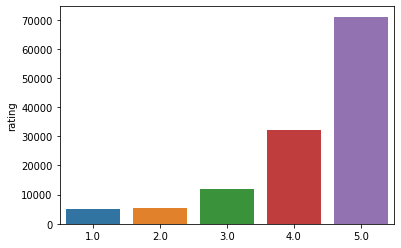

In [22]:
print((100*data_filtered['rating'].value_counts())/data_filtered['rating'].count())
sns.barplot(x = data_filtered['rating'].value_counts().index, y=data_filtered['rating'].value_counts())
plt.show()

The number of ratings with 5 and 4 have gone up with the filter. It is already seen that the users who are rating more often tend to rate higher than one of users

In [23]:
data_filtered.shape

(125871, 3)

In [24]:
data_filtered.shape[0]/data.shape[0]

0.016086817771044495

With the filtering we are using only 1.6% of the available data

#Popularity Recommender Model
3 Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

4 Build Popularity Recommender model.

6 Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [25]:
from sklearn.model_selection import train_test_split
data_filtered_train, data_filtered_test,  = train_test_split(data_filtered, test_size=0.30, random_state=0)
print("Train data shape:", data_filtered_train.shape)
print("Test data shape:", data_filtered_test.shape)

Train data shape: (88109, 3)
Test data shape: (37762, 3)


In [0]:
#Products that are rated most can be considered as most popular. Take the filtered data and check for the highest rating and list them
#In popularity based model, we dont see if this user has already rated on not. Only product is considered. The same list will 
#be the list for all users. There is no user specific customization. 

In [27]:
data_filtered_train.sample(2)

user_id  product_id  rating
1426400  A2R6RA8FRBS608  B000V4URJ4     5.0
4409930  A3AG5QAT8L0I3R  B004S464WM     2.0

In [28]:
print(data_filtered['product_id'].nunique(), data_filtered_train['product_id'].nunique(), data_filtered_test['product_id'].nunique())

48190 38226 21292


There is a possibility that the product_id present in the testing is not available while training. It would be like a new product which was not present while the model was trained 

In [29]:
#First get the mean of all the ratings per product.
ratings_mean_count = pd.DataFrame(data_filtered_train.groupby('product_id')['rating'].mean())
ratings_mean_count.shape

(38226, 1)

In [30]:
ratings_mean_count.head(2)

rating
product_id        
0594451647     5.0
0594481813     3.0

In [0]:
#Now get the number of ratings for each of the products
ratings_mean_count['rating_counts'] = pd.DataFrame(data_filtered_train.groupby('product_id')['rating'].count())

In [0]:
#Just get the product_id as one of the columns
ratings_mean_count.reset_index(inplace=True)

In [33]:
ratings_mean_count.dtypes

product_id        object
rating           float64
rating_counts      int64
dtype: object

In [0]:
#Sort the columns based on ratings_counts [Highest rated means more popular] and then based on rating
ratings_mean_count.sort_values(['rating_counts', 'rating'], ascending=[False, False], inplace=True)

In [35]:
ratings_mean_count.head(10)

product_id    rating  rating_counts
30847  B0088CJT4U  4.187970            133
30287  B007WTAJTO  4.637097            124
19647  B003ES5ZUU  4.844262            122
8752   B000N99BBC  4.763158            114
30555  B00829THK0  4.474227             97
30559  B00829TIEK  4.443299             97
17384  B002R5AM7C  4.117021             94
31107  B008DWCRQW  4.054945             91
17573  B002SZEOLG  4.285714             84
22744  B004CLYEDC  4.658537             82

The list of 10 products can be use the most popular products irrespective of the user

In [0]:
#Make a function to get the rating of a given product based on the table build
#Function returns nan if the product id is not in the training data
def get_popularity_rating_product(prod_id):
  #check if there is this product in the training data
  rating = 0.
  if (ratings_mean_count.product_id==prod_id).sum() > 0:
    rating = ratings_mean_count[ratings_mean_count.product_id==prod_id]['rating']
  else:
    rating = np.nan
  return rating

In [0]:
data_filtered_test_popularity_eval = data_filtered_test.copy()
data_filtered_test_popularity_eval['pred_rating'] = 0.
data_filtered_test_popularity_eval.set_index('product_id', inplace=True)
for prod_id in data_filtered_test_popularity_eval.index.unique():
  data_filtered_test_popularity_eval.at[prod_id, 'pred_rating'] = get_popularity_rating_product(prod_id)

In [38]:
data_filtered_test_popularity_eval.head()

user_id  rating  pred_rating
product_id                                     
B009UHO1L8  A3JU990UTN5RQP     5.0          NaN
B003PNIQCI  A2VJ5ALN1BIV3B     5.0          NaN
B00006B7DA   A2NQMVTQ4PVLL     4.0     4.363636
B00FH66AW4  A25UZ7MA72SMKM     4.0     4.200000
B006UAJ690   A680RUE1FDO8B     5.0          NaN

In [39]:
print("Number of products that are only present in the test data and not in the train data", data_filtered_test_popularity_eval.pred_rating.isnull().sum())

Number of products that are only present in the test data and not in the train data 10795


For the 10795 product we cannot estimate a rating as they had no rating from the users in the training set. 

We can use fillna to mean. But since our goal is to check the model perfromance we can simply drop these products and then do the RMSE

In [40]:
print(data_filtered_test_popularity_eval.shape)
data_filtered_test_popularity_eval.dropna(inplace=True)
print(data_filtered_test_popularity_eval.shape)

(37762, 3)
(26967, 3)


In [41]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true = data_filtered_test_popularity_eval['rating'], y_pred = data_filtered_test_popularity_eval['pred_rating'])
print("RMSE of popularity based model is ", np.sqrt(mse))

RMSE of popularity based model is  1.092161482923713


# Collaborative Filtering model.
3 Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

5 Build Collaborative Filtering model.

6 Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [42]:
#If surprise package is not installed then install it
!pip install scikit-surprise

In [0]:
#Prepare the train test split using surprise package for handling the same in SVD
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
reader = Reader()
data_filtered_svd = Dataset.load_from_df(data_filtered, reader)
data_filtered_train_svd, data_filtered_test_svd = train_test_split(data_filtered_svd, test_size=0.30, random_state=0)

In [44]:
#Build the colab model with SVD. Fit the model with training data
from surprise import SVD, accuracy
svd_model = SVD()
svd_model.fit(data_filtered_train_svd)

In [0]:
#get the ratings prediction for the test data using the model created
pred_ratings_svd = svd_model.test(data_filtered_test_svd)

In [47]:
#Check if there was a not possible estimation
test_pred_svd_df = pd.DataFrame(pred_ratings_svd)
test_pred_svd_df["was_impossible"] = [x["was_impossible"] for x in test_pred_svd_df["details"]]
test_pred_svd_df[test_pred_svd_df['was_impossible']].shape

(0, 6)

Even though the products in the train where not present in the test and new users were present in test, the cold start problem was not seen since surprise managed it with one of them. was_impossible was never set to True

In [48]:
test_pred_svd_df.head(2)

uid         iid  ...                    details  was_impossible
0  A3MFORLOKIOEQY  B003M8HWDA  ...  {'was_impossible': False}           False
1   AHR86ZEYETLJI  B00013M6NK  ...  {'was_impossible': False}           False

[2 rows x 6 columns]

In [49]:
from surprise import accuracy
accuracy.rmse(pred_ratings_svd, verbose=True)

RMSE: 0.9885


0.9885044013005301

# 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [0]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [0]:
top_products_per_user = pd.DataFrame(columns=['user_id', 'products'])
top_n = get_top_n(pred_ratings_svd, n=5)
users = []
products = []
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    users.append(uid)
    products.append([iid for [iid, _] in user_ratings])

top_products_per_user['user_id'] = users
top_products_per_user['products'] = products
top_products_per_user.set_index('user_id', inplace=True)

In [52]:
#top_products_per_user dataframe consists of all the users top 10 listings of products. 
top_products_per_user.head()

products
user_id                                                          
A3MFORLOKIOEQY  [B00CKAOJA0, B000VX6XL6, B00G6IJ5NI, B004L9M4C...
AHR86ZEYETLJI   [B006EKIQYM, B0039BPG1K, B005LFT3GG, B005Y8BYO...
A21VM9WVF8EOSJ  [B000OG88KY, B002TA7VO2, B006WAGG14, B005N8W1M...
A3SL0HA6422W4M  [B00ENZRS76, B007WTAJTO, B0061JPXLU, B003IHUHG...
A35IX2GE0VC0JP  [B003ES5ZUU, B00FJWKYYG, B001S4OTS6, B004YHXXK...

In [53]:
#based on user id, the 10 top products can be accessed
top_products_per_user.loc['A100WO06OQR8BQ']

products    [B000IF51UQ, B00AJHDZSI, B00016BYHQ, B002XVBAK...
Name: A100WO06OQR8BQ, dtype: object

# 8. Summarise your insights.

Popularity based recommendtaion system is generic 
Colab Filtering is specific for each user based on their ratings. Model based collaborative filtering can be used if the database has user ratings [Not cold start]

In case of new customers [cold start], popularity based recommendation system may be considered since the user ratings are unknwown based on which a table of recommendatons is made. 